In [1]:
#Cell 0_ Just Imports_(Once per notebook)
import os, json, math, random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# optional deps (used for quick heuristics + polygon fill)
from skimage.morphology import binary_opening, disk
from skimage.draw import polygon

plt.rcParams["figure.dpi"] = 120
np.set_printoptions(precision=3, suppress=True)
random.seed(42); np.random.seed(42)

print("✅ Imports OK")


✅ Imports OK


In [2]:
#Cell 1_Globals_(Single place to edit)
# === EDIT THESE TWO ONLY ===
DATA_ROOT = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")  # KITTI train root
OUT_ROOT  = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs")  # where outputs go
FID       = "000010"  # pick any available id like "000007", "000123", etc.

# --- Derived paths
VELO_DIR  = DATA_ROOT / "velodyne"
LAB2_DIR  = DATA_ROOT / "label_2"
CALIB_DIR = DATA_ROOT / "calib"

# --- Create an incremented numeric run folder: ...\bev_npu_outputs\1, 2, 3, ...
OUT_ROOT.mkdir(parents=True, exist_ok=True)
existing = [int(p.name) for p in OUT_ROOT.iterdir() if p.is_dir() and p.name.isdigit()]
next_id = (max(existing) + 1) if existing else 1
RUN_DIR = OUT_ROOT / f"{next_id}"
(RUN_DIR / "bev_float").mkdir(parents=True, exist_ok=True)
(RUN_DIR / "bev_u8").mkdir(parents=True, exist_ok=True)
(RUN_DIR / "masks").mkdir(parents=True, exist_ok=True)
(RUN_DIR / "overlays").mkdir(parents=True, exist_ok=True)

print("RUN_DIR:", RUN_DIR)

# --- BEV grid & ROI (KITTI-friendly defaults; tweak if needed)
cfg = {
    "x_range": (0.0, 70.4),    # forward meters
    "y_range": (-40.0, 40.0),  # left/right meters
    "z_range": (-2.5, 1.0),    # ground to hood-ish
    "H": 704,                  # rows  (x bins)
    "W": 800,                  # cols  (y bins)
    "q": {"count_cap": 5.0, "zvar_cap": 3.0}
}

# list available frame ids
ALL_IDS = sorted(p.stem for p in VELO_DIR.glob("*.bin"))
print("Frames available:", len(ALL_IDS), "example:", ALL_IDS[:5])


RUN_DIR: D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\7
Frames available: 7481 example: ['000000', '000001', '000002', '000003', '000004']


In [3]:
#Cell 2 (I/O Helpers)
def load_points(bin_path: Path) -> np.ndarray:
    """Read KITTI .bin [x,y,z,intensity] float32"""
    arr = np.fromfile(bin_path, dtype=np.float32)
    return arr.reshape(-1, 4)

def save_png(path: Path, img):
    import imageio.v2 as iio
    iio.imwrite(path, img)

print("✅ IO helpers ready")


✅ IO helpers ready


In [4]:
#Cell 3 (BEV Functions _rasterization + quantization)
def bev_from_points(points: np.ndarray, cfg: dict) -> np.ndarray:
    x, y, z, i = points.T
    xr, yr, zr = cfg["x_range"], cfg["y_range"], cfg["z_range"]
    H, W = cfg["H"], cfg["W"]

    m = (x>=xr[0])&(x<=xr[1])&(y>=yr[0])&(y<=yr[1])&(z>=zr[0])&(z<=zr[1])
    x, y, z, i = x[m], y[m], z[m], i[m]

    row_scale = (H - 1) / (xr[1] - xr[0])
    col_scale = (W - 1) / (yr[1] - yr[0])
    iy = np.floor((x - xr[0]) * row_scale).astype(np.int32)
    ix = np.floor((y - yr[0]) * col_scale).astype(np.int32)
    lin = iy * W + ix

    count = np.bincount(lin, minlength=H*W).astype(np.float32).reshape(H, W)
    sum_z  = np.bincount(lin, weights=z,   minlength=H*W).reshape(H, W)
    sum_z2 = np.bincount(lin, weights=z*z, minlength=H*W).reshape(H, W)
    sum_i  = np.bincount(lin, weights=i,   minlength=H*W).reshape(H, W)

    zmax = np.full(H*W, -1e9, dtype=np.float32)
    np.maximum.at(zmax, lin, z); zmax = zmax.reshape(H, W)

    eps   = 1e-6
    zmean = sum_z / np.maximum(count, eps)
    imean = sum_i / np.maximum(count, eps)
    zvar  = (sum_z2 / np.maximum(count, eps)) - zmean**2
    zvar  = np.clip(zvar, 0.0, None)

    return np.stack([count, zmax, zmean, imean, zvar], axis=0)

def quantize_bev_u8(bev: np.ndarray, cfg: dict) -> np.ndarray:
    zr = cfg["z_range"]
    count_cap, zvar_cap = cfg["q"]["count_cap"], cfg["q"]["zvar_cap"]

    q0 = np.clip((bev[0] / count_cap) * 255.0, 0, 255).astype(np.uint8)
    z_to_u8 = lambda arr: np.clip(((arr - zr[0]) / (zr[1] - zr[0])) * 255.0, 0, 255).astype(np.uint8)
    q1 = z_to_u8(bev[1])
    q2 = z_to_u8(bev[2])
    q3 = np.clip(bev[3] * 255.0, 0, 255).astype(np.uint8)
    q4 = np.clip((bev[4] / zvar_cap) * 255.0, 0, 255).astype(np.uint8)

    return np.stack([q0, q1, q2, q3, q4], axis=0)

print("✅ BEV fns ready")


✅ BEV fns ready


Frame 000010 | points: 115875
x[-60.4,78.4] y[-68.3,61.6] z[-14.1,2.9]


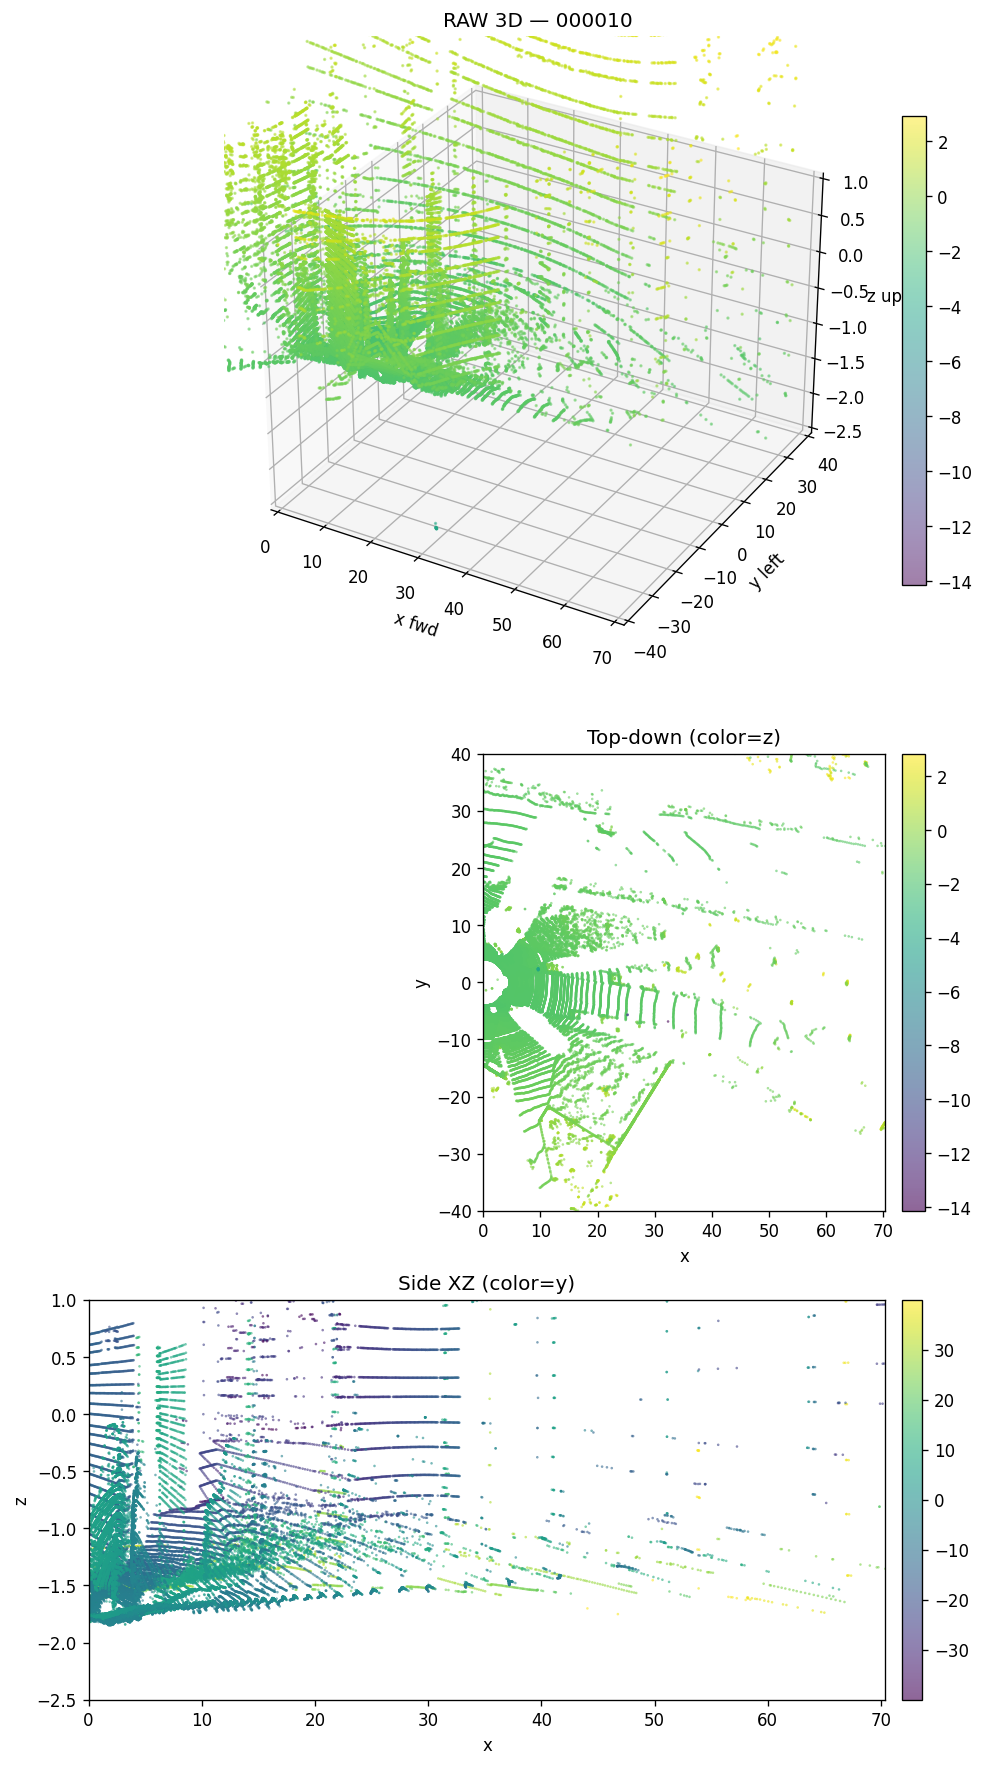

In [5]:
#Cell 4 (Raw Visualization for current FID)
bin_path = VELO_DIR / f"{FID}.bin"
raw = load_points(bin_path)
x, y, z, inten = raw.T
xr, yr, zr = cfg["x_range"], cfg["y_range"], cfg["z_range"]

print(f"Frame {FID} | points: {len(raw)}")
print(f"x[{x.min():.1f},{x.max():.1f}] y[{y.min():.1f},{y.max():.1f}] z[{z.min():.1f},{z.max():.1f}]")

Nplot = min(len(raw), 80000)
idx = np.random.choice(len(raw), size=Nplot, replace=False) if len(raw) > Nplot else np.arange(len(raw))
xs, ys, zs = x[idx], y[idx], z[idx]

fig = plt.figure(figsize=(9, 18))
gs = fig.add_gridspec(3,1, height_ratios=[2.2,1.6,1.4], hspace=0.18)

ax3d = fig.add_subplot(gs[0], projection='3d')
sc3d = ax3d.scatter(xs, ys, zs, c=zs, s=1, alpha=0.5, cmap='viridis')
ax3d.set_title(f"RAW 3D — {FID}"); ax3d.set_xlabel("x fwd"); ax3d.set_ylabel("y left"); ax3d.set_zlabel("z up")
ax3d.set_xlim(xr); ax3d.set_ylim(yr); ax3d.set_zlim(zr); fig.colorbar(sc3d, ax=ax3d, fraction=0.028, pad=0.06)

m = (x>=xr[0])&(x<=xr[1])&(y>=yr[0])&(y<=yr[1])
axXY = fig.add_subplot(gs[1])
scXY = axXY.scatter(x[m], y[m], c=z[m], s=0.3, alpha=0.6, cmap='viridis')
axXY.set_aspect('equal'); axXY.set_xlim(xr); axXY.set_ylim(yr)
axXY.set_title("Top-down (color=z)"); axXY.set_xlabel("x"); axXY.set_ylabel("y")
fig.colorbar(scXY, ax=axXY, fraction=0.028, pad=0.02)

axXZ = fig.add_subplot(gs[2])
scXZ = axXZ.scatter(x[m], z[m], c=y[m], s=0.3, alpha=0.6, cmap='viridis')
axXZ.set_xlim(xr); axXZ.set_ylim(zr)
axXZ.set_title("Side XZ (color=y)"); axXZ.set_xlabel("x"); axXZ.set_ylabel("z")
fig.colorbar(scXZ, ax=axXZ, fraction=0.028, pad=0.02)
plt.show()


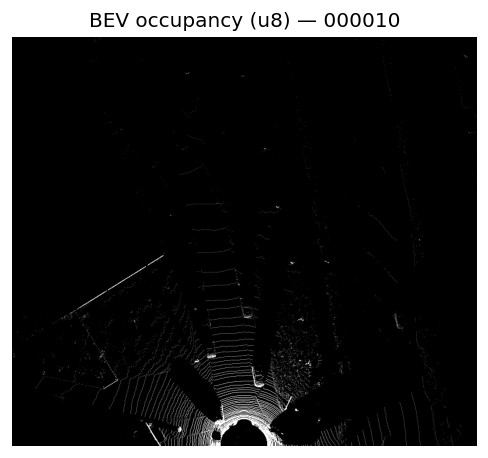

Saved: D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\7\bev_float\000010.npy | D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\7\bev_u8\000010.npy


In [6]:
#Cell 5 (Make and save BEV for current FID)
bev_f = bev_from_points(raw, cfg)
bev_u = quantize_bev_u8(bev_f, cfg)

np.save(RUN_DIR / "bev_float" / f"{FID}.npy", bev_f)
np.save(RUN_DIR / "bev_u8"    / f"{FID}.npy", bev_u)

plt.figure(figsize=(5,5)); plt.imshow(bev_u[0], origin='lower', cmap='gray')
plt.title(f"BEV occupancy (u8) — {FID}"); plt.axis('off'); plt.show()

print("Saved:", RUN_DIR / "bev_float" / f"{FID}.npy", "|", RUN_DIR / "bev_u8" / f"{FID}.npy")


frames detected: 1


golden: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


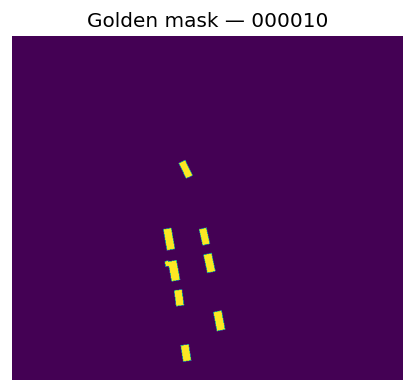

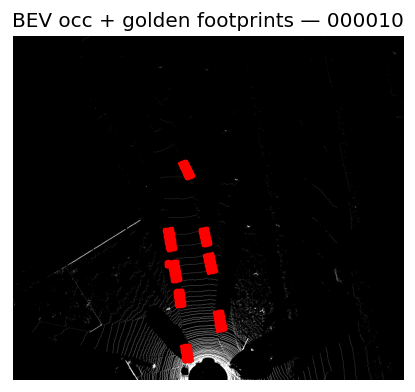

In [13]:
# Cell 6 — Build "golden" BEV masks from KITTI labels + save + quick overlay
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

CAL_DIR = Path(KITTI_ROOT) / "calib"
LAB_DIR = Path(KITTI_ROOT) / "label_2"
BEV_U8_DIR = RUN_DIR / "bev_u8"
GOLD_DIR = RUN_DIR / "golden"
(GOLD_DIR).mkdir(parents=True, exist_ok=True)

# --- helpers (robust to spaces/newlines in calib files) ---
def _parse_kv(line):
    if ":" not in line: return None, None
    k, v = line.split(":", 1)
    return k.strip(), v.strip()

def read_calib(fid):
    txt = (CAL_DIR / f"{fid}.txt").read_text().splitlines()
    R0_rect = None; Tr_v2c = None
    for ln in txt:
        k, v = _parse_kv(ln)
        if k == "R0_rect":
            R0_rect = np.fromstring(v, sep=" ").reshape(3,3)
        elif k == "Tr_velo_to_cam":
            Tr_v2c = np.fromstring(v, sep=" ").reshape(3,4)
    if R0_rect is None or Tr_v2c is None:
        raise RuntimeError(f"Bad calib for {fid}")
    return R0_rect, Tr_v2c

def rect_to_velo_matrix(R0_rect, Tr_v2c):
    R = R0_rect @ Tr_v2c[:, :3]
    t = R0_rect @ Tr_v2c[:, 3]
    T_v2r = np.eye(4, dtype=np.float32)
    T_v2r[:3,:3] = R; T_v2r[:3,3] = t
    return T_v2r

KEEP_CLASSES = {"Car","Van","Truck","Cyclist","Pedestrian"}  # you can extend

def load_labels(fid):
    lines = (LAB_DIR / f"{fid}.txt").read_text().strip().splitlines()
    out = []
    for ln in lines:
        parts = ln.split()
        cls = parts[0]
        if cls not in KEEP_CLASSES: 
            continue
        h,w,l = map(float, parts[8:11])
        x,y,z  = map(float, parts[11:14])    # camera rect coords
        ry     = float(parts[14])
        out.append((cls,h,w,l,x,y,z,ry))
    return out

def yaw_box3d_corners(l,w,h,x,y,z,ry):
    # corners in camera-rect frame (KITTI: x-right, y-down, z-forward)
    x_c =  np.array([ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2 ])
    y_c =  np.array([   0 ,   0 ,   0 ,   0 , -h , -h ,  -h ,  -h  ])
    z_c =  np.array([ w/2, -w/2, -w/2,  w/2, w/2, -w/2, -w/2,  w/2 ])
    c, s = np.cos(ry), np.sin(ry)
    X =  c*x_c + s*z_c + x
    Y =  y_c + y
    Z = -s*x_c + c*z_c + z
    return np.stack([X,Y,Z], axis=0)  # [3,8]

def rect_to_velo(points_rect, T_v2r):
    pts_h = np.vstack([points_rect, np.ones((1, points_rect.shape[1]), dtype=np.float32)])  # [4,N]
    T_r2v = np.linalg.inv(T_v2r)
    pts_v = T_r2v @ pts_h
    return pts_v[:3]

def polyfill_bev(poly_xy, H, W, xr, yr):
    # rasterize a convex quad (top face) onto BEV mask
    from matplotlib.path import Path as MplPath
    ys, xs = np.mgrid[0:H, 0:W]
    # grid → meters
    row_scale = (H - 1) / (xr[1] - xr[0])
    col_scale = (W - 1) / (yr[1] - yr[0])
    gx = xr[0] + ys / row_scale    # forward x (m)
    gy = yr[0] + xs / col_scale    # left y (m)
    pts = np.stack([gx.ravel(), gy.ravel()], axis=1)
    mask = MplPath(poly_xy).contains_points(pts).reshape(H,W)
    return mask

def golden_mask_for_frame(fid, cfg):
    H,W = cfg["H"], cfg["W"]
    xr, yr = cfg["x_range"], cfg["y_range"]
    g = np.zeros((H,W), dtype=np.uint8)

    R0, Tv2c = read_calib(fid)
    T_v2r = rect_to_velo_matrix(R0, Tv2c)

    for cls,h,w,l,x,y,z,ry in load_labels(fid):
        corners_r = yaw_box3d_corners(l,w,h,x,y,z,ry)      # [3,8]
        corners_v = rect_to_velo(corners_r, T_v2r)         # [3,8] in Velodyne (x fwd, y left, z up)
        # take the top face (indices 0..3 here; same XY footprint as bottom)
        top = corners_v[:2, :4].T  # [[x,y],...]
        # keep only footprint inside our BEV ROI
        poly = top[:, :2]
        # rasterize
        mask = polyfill_bev(poly, H, W, xr, yr)
        g[mask] = 255
    return g

# ---- build golden for all BEVs in RUN_DIR (quick subset) ----
bevs = sorted([p.stem for p in BEV_U8_DIR.glob("*.npy")])
print("frames detected:", len(bevs))
for fid in tqdm(bevs, desc="golden"):
    g = golden_mask_for_frame(fid, cfg)
    np.save(GOLD_DIR / f"{fid}.npy", g)

# ---- visualize one ----
FID = bevs[0] if bevs else "000000"
occ = np.load(BEV_U8_DIR / f"{FID}.npy")[0]   # occupancy for background
g   = np.load(GOLD_DIR / f"{FID}.npy")

plt.figure(figsize=(4.2,4.2)); plt.imshow(g, origin='lower'); plt.title(f"Golden mask — {FID}"); plt.axis('off'); plt.show()

plt.figure(figsize=(4.2,4.2)); 
plt.imshow(occ, origin='lower', cmap='gray'); 
ys, xs = np.where(g>0); plt.scatter(xs, ys, s=1, c='r')
plt.title(f"BEV occ + golden footprints — {FID}"); plt.axis('off'); plt.show()


In [14]:
# Cell 7 — Build BEV tile dataset from bev_u8 + golden masks
from pathlib import Path
import numpy as np, random
from tqdm import tqdm

TILE   = 256
STRIDE = 256
IN_CH  = [0,1,3]     # occ, z_max, intensity
MIN_POS_PCT = 0.2    # keep tiles with ≥0.2% positive pixels
MAX_FRAMES  = 800    # limit for a first run

DS_DIR = RUN_DIR / "dataset_v1"
for s in ["train/imgs","train/msk","val/imgs","val/msk"]:
    (DS_DIR / s).mkdir(parents=True, exist_ok=True)

bevs = sorted([p.stem for p in (RUN_DIR/"bev_u8").glob("*.npy")])
golds= set(p.stem for p in (RUN_DIR/"golden").glob("*.npy"))
ids = [fid for fid in bevs if fid in golds]
random.seed(42); random.shuffle(ids)
ids = ids[:MAX_FRAMES]

split = int(0.8*len(ids))
train_ids, val_ids = ids[:split], ids[split:]

def tiles(arr, tile=TILE, stride=STRIDE):
    H,W = arr.shape[-2], arr.shape[-1]
    for y in range(0, H-tile+1, stride):
        for x in range(0, W-tile+1, stride):
            yield y,x,arr[..., y:y+tile, x:x+tile]

def dump(ids, name):
    kept=tot=0
    for fid in tqdm(ids, desc=f"build {name}"):
        img = np.load(RUN_DIR/"bev_u8"/f"{fid}.npy")[IN_CH].astype(np.float32)/255.0  # [C,H,W]
        msk = np.load(RUN_DIR/"golden"/f"{fid}.npy").astype(np.float32)/255.0         # [H,W]
        msk = msk[None]  # [1,H,W]
        for y,x,patch in tiles(img):
            pm = msk[..., y:y+TILE, x:x+TILE][0]     # [T,T]
            tot += 1
            if pm.mean()*100.0 >= MIN_POS_PCT:
                name_np = f"{fid}_{y:04d}_{x:04d}.npy"
                np.save(DS_DIR/name/"imgs"/name_np, patch)  # [C,T,T] float32
                np.save(DS_DIR/name/"msk"/name_np,  pm)     # [T,T]  float32
                kept += 1
    print(f"{name}: kept {kept}/{tot} tiles")

dump(train_ids, "train")
dump(val_ids,   "val")


build train: 0it [00:00, ?it/s]


train: kept 0/0 tiles


build val: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.09it/s]

val: kept 2/6 tiles


In [17]:
# Cell 8 — Train a tiny BEV segmentation CNN on tiles
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cpu")

class NpyTiles(Dataset):
    def __init__(self, root):
        p = Path(root); self.imgs = sorted((p/"imgs").glob("*.npy"))
        self.msks = [ (p/"msk"/fn.name) for fn in self.imgs ]
    def __len__(self): return len(self.imgs)
    def __getitem__(self, i):
        x = np.load(self.imgs[i]).astype(np.float32)
        y = np.load(self.msks[i]).astype(np.float32)
        return torch.from_numpy(x), torch.from_numpy(y)

train_ds = NpyTiles(DS_DIR/"train")
val_ds   = NpyTiles(DS_DIR/"val")
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=0)
print(f"tiles: train={len(train_ds)}, val={len(val_ds)}, in_ch={len(IN_CH)}")

class TinyBEV(nn.Module):
    def __init__(self, in_ch=len(IN_CH), ch=32):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, ch, 3, padding=1), nn.ReLU(),
                                  nn.Conv2d(ch, ch, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)  # 256->128
        self.enc2 = nn.Sequential(nn.Conv2d(ch, ch*2, 3, padding=1), nn.ReLU(),
                                  nn.Conv2d(ch*2, ch*2, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)  # 128->64
        self.bot   = nn.Sequential(nn.Conv2d(ch*2, ch*4, 3, padding=1), nn.ReLU())
        self.up1   = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1  = nn.Sequential(nn.Conv2d(ch*4, ch*2, 3, padding=1), nn.ReLU())
        self.up2   = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.head  = nn.Conv2d(ch*2, 1, 1)  # logits
    def forward(self, x):
        x1 = self.enc1(x); x = self.pool1(x1)
        x2 = self.enc2(x); x = self.pool2(x2)
        x  = self.bot(x)
        x  = self.up1(x); x = self.dec1(x)
        x  = self.up2(x); x = self.head(x)
        return x

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2*(probs*targets).sum()+eps
    den = probs.sum()+targets.sum()+eps
    return 1 - num/den

model = TinyBEV().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
bce   = nn.BCEWithLogitsLoss()

def eval_iou(loader):
    model.eval(); inter=0; union=0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            p = (torch.sigmoid(model(x))>0.5).float()
            inter += (p*y.unsqueeze(1)).sum().item()
            union += ((p+y.unsqueeze(1))>0).float().sum().item()
    return (inter/union) if union>0 else 0.0

EPOCHS = 8  # start small; later try 20–30
for ep in range(1, EPOCHS+1):
    model.train(); total=0; n=0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = bce(logits, y.unsqueeze(1)) + dice_loss(logits, y.unsqueeze(1))
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*x.size(0); n += x.size(0)
    val_i = eval_iou(val_loader)
    print(f"epoch {ep:02d} | train_loss {total/n:.4f} | val IoU {val_i:.3f}")

torch.save(model.state_dict(), RUN_DIR/"tiny_bev.pt")
print("Saved:", RUN_DIR/"tiny_bev.pt")


ValueError: num_samples should be a positive integer value, but got num_samples=0